# PSO


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
!pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct

# 1-D Fourier Series

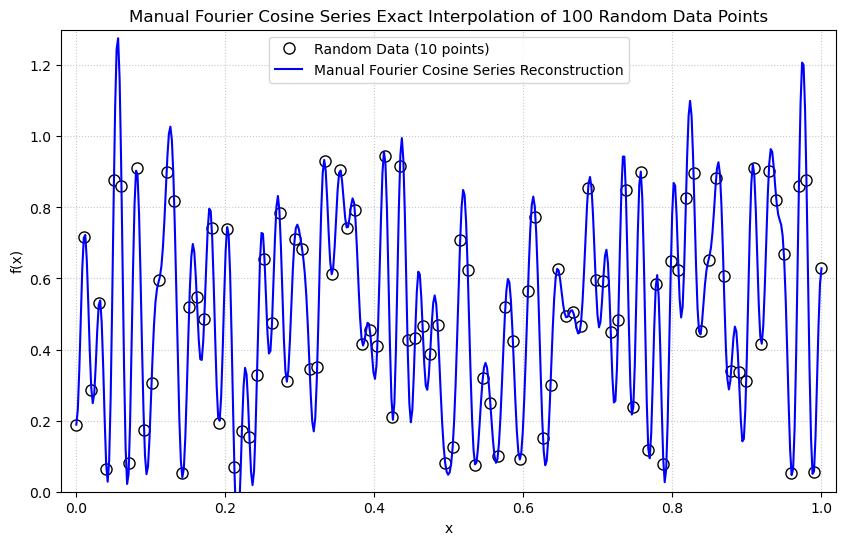

In [5]:
# Original data
N = 100
L_interval = 1.0  # Interval length for normalization
x = np.linspace(0, L_interval, N) 
np.random.seed(12) # 为了结果可复现，设置随机种子
# 生成模拟的随机 y 值
f = np.random.rand(N) * 0.9 + 0.05 

# --- Normalize the x domain ---
# Find the min and max of your x data
x_min = np.min(x)
x_max = np.max(x)

# Create a normalized version of x, mapping [x_min, x_max] to [0, 1]
x_normalized = (x - x_min) / (x_max - x_min)

# DCT-I transform (get cosine coefficients) - IMPORTANT: DCT is performed on f,
# not x. The spacing of x only matters for the implicit basis functions.
a = dct(f, type=1)

# Fitted function: Use IDCT-I to recover values at original sampling points
# This is mainly for checking the reconstruction at the sample points.
f_fit = idct(a, type=1) / (N - 1)

# High-resolution points for plotting the fitted curve
x_highres = np.linspace(x_min, x_max, 500) # Use the original x range for high-res points

# Manually reconstruct the high-resolution fitted values using cosine expansion
def DFT(x_highres, N):
    x_highres = (x_highres - x_min) / (x_max - x_min)  # Normalize high-res x
    f_highres = np.zeros_like(x_highres)
    for n in range(N):
        coef = a[n]
        if n == 0 or n == N - 1:
            coef /= 2  # DCT-I boundary terms have a weight of 1/2
        # Use the normalized x_highres here!
        f_highres += coef * np.cos(n * np.pi * x_highres)

    f_highres /= (N - 1)  # Scaling factor for DCT-I inverse
    return f_highres


# 绘图
plt.figure(figsize=(10, 6))
# 绘制原始数据点
plt.plot(x, f, 'o', 
         markeredgecolor='black', markerfacecolor='white', markersize=8, 
         label='Random Data (10 points)')
# 绘制手动重建的傅里叶余弦级数曲线
plt.plot(x_highres, DFT(x_highres, N), '-', 
         color='blue', linewidth=1.5, 
         label='Manual Fourier Cosine Series Reconstruction')

plt.title(f'Manual Fourier Cosine Series Exact Interpolation of {N} Random Data Points')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0, 1.3) # 调整 Y 轴范围以更好地可视化
plt.xlim(-0.02, L_interval + 0.02) # 调整 X 轴范围
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()



# PSO

In [104]:

# 设置迭代次数
max_iter = 100


# 定义PSO的目标函数
def fourier_objective_function(x):
    """
    PSO目标函数，基于傅里叶余弦级数。
    输入 x 是标量（因为 n_dim=1），返回 -f(x) 以寻找最大值。
    """
    # 确保 x 是标量或单元素数组
    x = np.array(x).flatten()[0]  # 提取标量值
    # 计算傅里叶余弦级数的值
    result = DFT(x, N)
    return -result

# 初始化 PSO
pso = PSO(func=fourier_objective_function, n_dim=1, pop=10, max_iter=max_iter,
          lb=[0], ub=[1],w=0.5, c1=1, c2=1.1)

pso.record_mode = True
pso.run()


(array([0.05551577]), array([-1.28247605]))

# Recompute the Fourier series curve for plotting

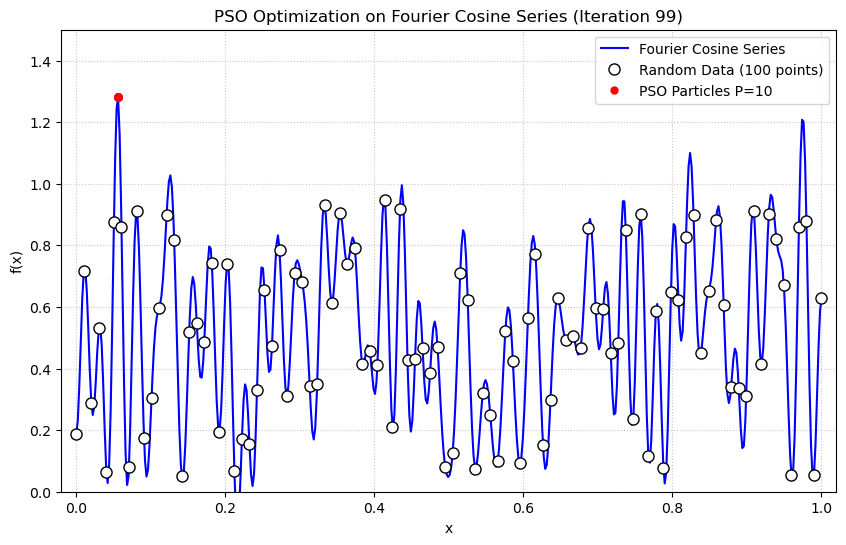

In [105]:


# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('PSO Optimization on Fourier Cosine Series', loc='center')

# Plot the Fourier series curve (static background)
ax.plot(x_highres, DFT(x_highres, N), '-',
        color='blue', linewidth=1.5, label='Fourier Cosine Series')
# Plot original data points
ax.plot(x, f, 'o',
        markeredgecolor='black', markerfacecolor='white', markersize=8,
        label=f'Random Data ({N} points)')

# Initialize scatter plot for particles
line, = ax.plot([], [], 'r.', markersize=10, label='PSO Particles P=10')

# Set axis limits
ax.set_xlim(-0.02, L_interval + 0.02)
ax.set_ylim(0, 1.5)  # Adjust based on your data range
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid(True, linestyle=':', alpha=0.7)

# Enable interactive mode
plt.ion()

# Animation update function
def update_scatter(frame):
    # frame = i * 10 + j, where i is iteration, j is interpolation step
    i, j = frame // 10, frame % 10
    ax.set_title(f'PSO Optimization on Fourier Cosine Series (Iteration {i})')
    
    X_list = pso.record_value['X']
    V_list = pso.record_value['V']
    # Get particle positions for iteration i
    X_tmp = X_list[i] + V_list[i] * j / 10.0  # Interpolate using velocity
    X_tmp = X_tmp.flatten()  # Ensure X_tmp is 1D array of positions
    
    # Compute f(x) for each particle's position
    Y_tmp = DFT(X_tmp, N)
    
    # Update scatter plot
    plt.setp(line, 'xdata', X_tmp, 'ydata', Y_tmp)
    
    return line,

# Create animation
ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)

# Save animation as GIF
ani.save('pso_fourier_N=100.gif', writer='pillow')

# Show plot
plt.show()